In [1]:
import pandas as pd
import seaborn as sns
import ast

Let's start by looking at the Drugs@FDA data, which consists of approved drugs. 

In [2]:
drugsfda = pd.read_csv('data/drugsfda.csv')

In [3]:
drugsfda.describe()

,application_number,openfda.spl_id,openfda.spl_set_id,openfda.product_ndc,openfda.substance_name
count,25458,11010,11010,11010,10692
unique,25458,10478,10478,10994,2043
top,NDA020080,['598a4afe-c4fa-4c32-8f68-6a01a07e922e'],['b15200fb-1826-472b-a907-e677a272513b'],['63323-651'],['CLOBETASOL PROPIONATE']
freq,1,9,9,3,78


In [4]:
drugsfda.isna().sum()/len(drugsfda)

application_number        0.000000
openfda.spl_id            0.567523
openfda.spl_set_id        0.567523
openfda.product_ndc       0.567523
openfda.substance_name    0.580014
dtype: float64

application_number is the table's primary key. The other fields are foreign keys and the drug's substance name. Note that 58% of the rows have null substance name. Let's look at the most common substances. 

openfda.substance_name is a list of substances, so let's explode it before analyzing. 

In [5]:
drugsfda['openfda.substance_name'] = drugsfda['openfda.substance_name'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)

In [6]:
substances = drugsfda['openfda.substance_name'].explode()

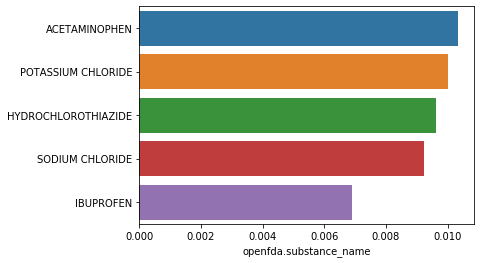

In [7]:
sns.barplot(
    y=substances.value_counts().head().index,
    x=substances.value_counts(normalize=True).head()
)

Acetaminophen is the most common substance among approved drugs with non-null substance_name. 

Now let's take a look at the NDC data, which consists of all manufactured drugs (both approved and unapproved) reported to the FDA.

In [8]:
ndc = pd.read_csv('data/ndc.csv')

In [9]:
ndc.describe()

,marketing_start_date,marketing_end_date
count,1.316250e+05,5.270000e+03
mean,2.012519e+07,2.023363e+07
std,1.124364e+05,1.400309e+05
min,1.900010e+07,2.022031e+07
25%,2.010092e+07,2.022073e+07
50%,2.016101e+07,2.023013e+07
75%,2.020011e+07,2.024022e+07
max,2.022031e+07,3.031021e+07


In [10]:
ndc.nunique()

product_id                 131625
product_ndc                129207
spl_id                     108198
application_number          11566
dea_schedule                    5
dosage_form                   142
finished                        2
marketing_category             16
marketing_start_date         8298
marketing_end_date            929
openfda.pharm_class_cs        510
openfda.pharm_class_epc       831
openfda.pharm_class_pe        145
openfda.pharm_class_moa       321
pharm_class                  1857
product_type                   10
route                         180
dtype: int64

product_id is the table's primary key.

In [11]:
ndc.isna().sum()/len(ndc)

product_id                 0.000000
product_ndc                0.000000
spl_id                     0.000000
application_number         0.254283
dea_schedule               0.954363
dosage_form                0.000000
finished                   0.000000
marketing_category         0.000000
marketing_start_date       0.000000
marketing_end_date         0.959962
openfda.pharm_class_cs     0.874454
openfda.pharm_class_epc    0.770127
openfda.pharm_class_pe     0.897611
openfda.pharm_class_moa    0.890036
pharm_class                0.480053
product_type               0.000000
route                      0.162910
dtype: float64

Some fields are missing a large percentage of their values. This could pose challenges for predicting approval. For example, if there is a relationship between missing a field and approval, then simply removing records missing that field will bias the training data. Futhermore, most of the fields are categorical, so attempting to impute missing values could also bias the dataset. 

Drugs with a null application_number have not been approved. Let's take a closer look at that field since we're interested in predicting FDA approval. 

In [12]:
def is_approved(application_number):
    if pd.isna(application_number):
        return 0
    else:
        return 1

In [13]:
ndc['approved'] = ndc['application_number'].apply(is_approved)

In [14]:
ndc['approved'].value_counts(normalize=True)

1    0.745717
0    0.254283
Name: approved, dtype: float64

About 75% of drugs have been approved. This presents an imbalanced class problem that will need to be addressed prior to model training. 

Now let's compare distributions of various fields between approved and unapproved drugs. 

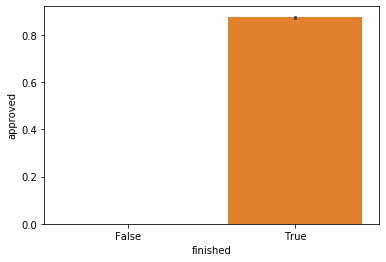

In [15]:
sns.barplot(
    data=ndc,
    x='finished',
    y='approved'
)

0% of unfinished products are approved. That's because the FDA does not reivew unfinished products. We should therefore only include finished products to avoid biasing our model. 

In [16]:
ndc_fin = ndc.query('finished == True').copy()

In [17]:
ndc_fin['approved'].value_counts(normalize=True)

1    0.874362
0    0.125638
Name: approved, dtype: float64

87% of finished drugs are approved. That means we're dealing with more imbalanced classes than it first appeared. This problem must be addressed to avoid training a useless model that simply always predicts "approved". 

In [18]:
ndc_fin['dea_schedule'].fillna('unscheduled', inplace=True)

In [19]:
approval_by_schedule = ndc_fin.groupby('dea_schedule')['approved'].mean().sort_values(ascending=False)

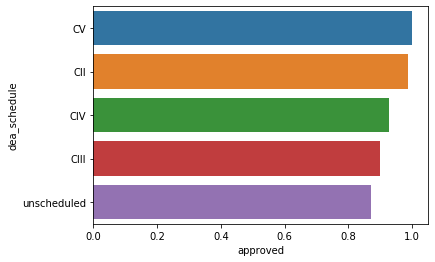

In [20]:
sns.barplot(
    x=approval_by_schedule,
    y=approval_by_schedule.index
)

There is quite a bit of variance in approval rate across DEA schedules, so this field could be a valuable predictor of approval.

In [21]:
approval_by_dosage_form = ndc_fin.groupby('dosage_form')['approved'].mean().sort_values(ascending=False)

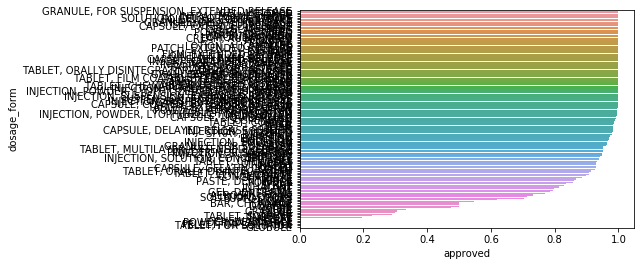

In [22]:
sns.barplot(
    x=approval_by_dosage_form,
    y=approval_by_dosage_form.index
)

There appears to be a good amount of variance in approval rate across dosage form, so this field could be a valuable predictor. The high cardinality makes it difficult to read the barplot, so let's just look at the approval rates of the most common dosage forms. 

In [23]:
top_dosage_forms = ndc_fin['dosage_form'].value_counts().head(20).index

In [24]:
approval_by_dosage_form = ndc_fin[ndc_fin['dosage_form'].isin(top_dosage_forms)].groupby('dosage_form')['approved'].mean().sort_values(ascending=False)

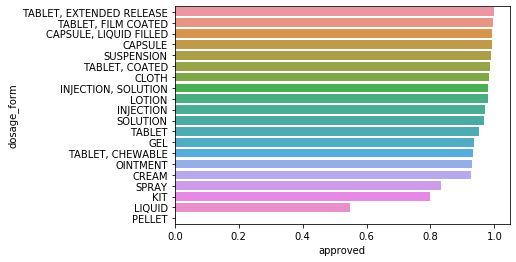

In [25]:
sns.barplot(
    x=approval_by_dosage_form,
    y=approval_by_dosage_form.index
)

Most of the top dosage forms have very high approval rates. LIQUID and PELLET are exceptions. 

In [26]:
approval_by_marketing_category = ndc_fin.groupby('marketing_category')['approved'].mean().sort_values(ascending=False)

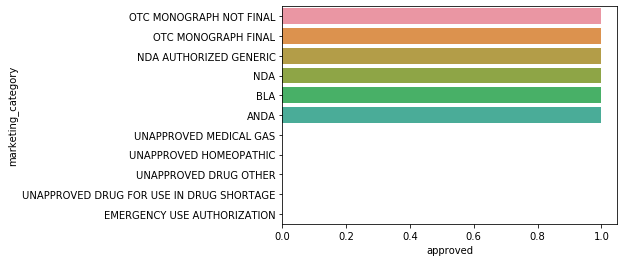

In [27]:
sns.barplot(
    x=approval_by_marketing_category,
    y=approval_by_marketing_category.index
)

It appears that marketing_category is not known until _after_ FDA review, so we should not include it in our model. 

In order to analyze marketing_start_date, we first need to change it from a string to a datetime. 

In [28]:
ndc_fin['marketing_start_date'] = pd.to_datetime(ndc_fin['marketing_start_date'], format='%Y%m%d')

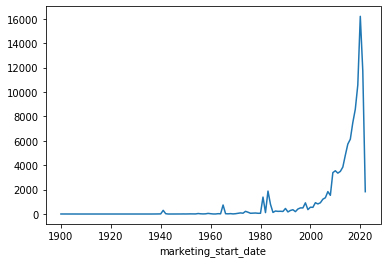

In [29]:
ndc_fin.groupby([ndc_fin['marketing_start_date'].dt.year]).size().plot()

The yearly number of new drugs brought to market has increased exponentially since 2000. 

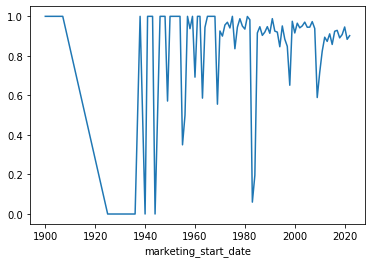

In [30]:
ndc_fin.groupby([ndc_fin['marketing_start_date'].dt.year])['approved'].mean().plot()

There is quite a bit of variance in the yearly approval rates. Though in the past few decades it seems like the mean has hovered around 75%, with a handful of years falling much lower. Let's see if there's any annual seasonality by aggregating by month. 

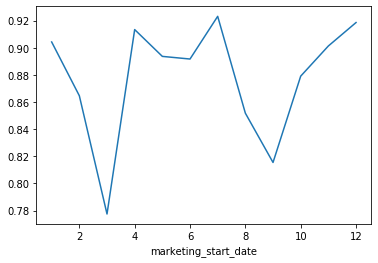

In [31]:
ndc_fin.groupby([ndc_fin['marketing_start_date'].dt.month])['approved'].mean().plot()

Interesting! The approval rate of drugs brought to market in July is over 10 percentage points higher than that of drugs brought to market in March. If this pattern is not a fluke, it could be leveraged by our company to maximize its FDA approval odds. 

The chemical structure pharmaceutical class field is a list, so let's explode it before analyzing. 

In [32]:
ndc_fin['openfda.pharm_class_cs'] = ndc_fin['openfda.pharm_class_cs'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else 'N/A')

In [33]:
cs = ndc_fin[['openfda.pharm_class_cs', 'approved']].explode('openfda.pharm_class_cs')

In [34]:
top_cs = cs['openfda.pharm_class_cs'].value_counts().head(20).index

In [35]:
approval_by_cs = cs[cs['openfda.pharm_class_cs'].isin(top_cs)].groupby('openfda.pharm_class_cs')['approved'].mean().sort_values(ascending=False)

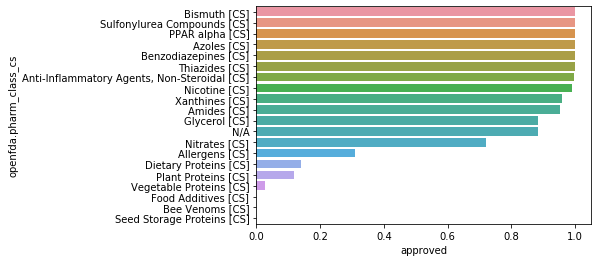

In [36]:
sns.barplot(
    x=approval_by_cs,
    y=approval_by_cs.index
)

Some chemical structure classes have a 0% approval rate, so this field could be a useful predictor. 

The established pharmaceutical class field is a list, so let's explode it before analyzing. 

In [37]:
ndc_fin['openfda.pharm_class_epc'] = ndc_fin['openfda.pharm_class_epc'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else 'N/A')

In [38]:
epc = ndc_fin[['openfda.pharm_class_epc', 'approved']].explode('openfda.pharm_class_epc')

In [39]:
top_epc = epc['openfda.pharm_class_epc'].value_counts().head(20).index

In [40]:
approval_by_epc = epc[epc['openfda.pharm_class_epc'].isin(top_epc)].groupby('openfda.pharm_class_epc')['approved'].mean().sort_values(ascending=False)

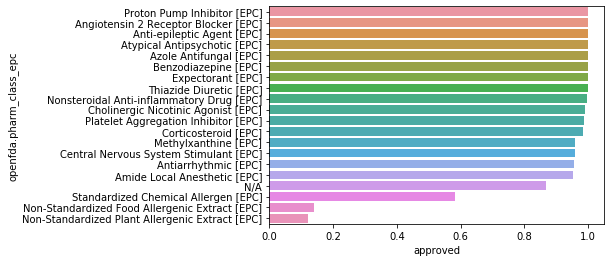

In [41]:
sns.barplot(
    x=approval_by_epc,
    y=approval_by_epc.index
)

Some Established Pharma Classes have significantly lower approval rates, so this field could be a useful predictor. 

The physiologic effect or pharmacodynamic effect class field is a list, so let's explode it before analyzing. 

In [42]:
ndc_fin['openfda.pharm_class_pe'] = ndc_fin['openfda.pharm_class_pe'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else 'N/A')

In [43]:
pe = ndc_fin[['openfda.pharm_class_pe', 'approved']].explode('openfda.pharm_class_pe')

In [44]:
top_pe = pe['openfda.pharm_class_pe'].value_counts().head(20).index

In [45]:
approval_by_pe = pe[pe['openfda.pharm_class_pe'].isin(top_pe)].groupby('openfda.pharm_class_pe')['approved'].mean().sort_values(ascending=False)

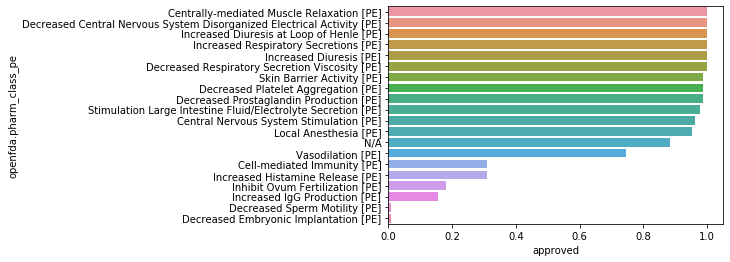

In [46]:
sns.barplot(
    x=approval_by_pe,
    y=approval_by_pe.index
)

Some Physiologic effect or pharmacodynamic effect classes have very low approval rates, so this field could be a useful predictor as well. 

The mechanism of action class field is a list, so let's explode it before analyzing. 

In [47]:
ndc_fin['openfda.pharm_class_moa'] = ndc_fin['openfda.pharm_class_moa'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else 'N/A')

In [48]:
moa = ndc_fin[['openfda.pharm_class_moa', 'approved']].explode('openfda.pharm_class_moa')

In [49]:
top_moa = moa['openfda.pharm_class_moa'].value_counts().head(20).index

In [50]:
approval_by_moa = moa[moa['openfda.pharm_class_moa'].isin(top_moa)].groupby('openfda.pharm_class_moa')['approved'].mean().sort_values(ascending=False)

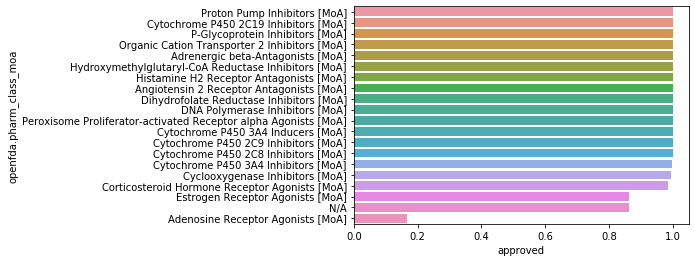

In [51]:
sns.barplot(
    x=approval_by_moa,
    y=approval_by_moa.index
)

Some mechanism of action classes have very low approval rates, so this field might be a useful predictor. 

In [52]:
approval_by_product_type = ndc_fin.groupby('product_type')['approved'].mean().sort_values(ascending=False)

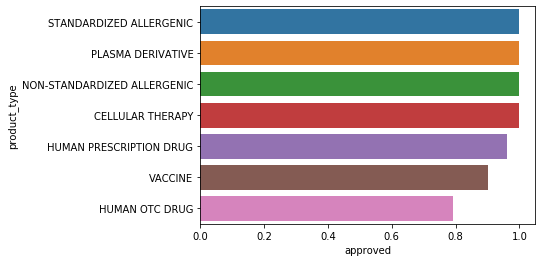

In [53]:
sns.barplot(
    x=approval_by_product_type,
    y=approval_by_product_type.index
)

Over the counter drugs have the lowest approval rate, followed by vaccines. 

The route field is a list of routes, so let's explode it to calculate the approval rate associated with each individual route.  

In [54]:
ndc_fin['route'] = ndc_fin['route'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else 'N/A') # evaluate the string as a list 

In [55]:
routes = ndc_fin[['route', 'approved']].explode('route')

In [56]:
top_routes = routes['route'].value_counts().head(20).index

In [57]:
approval_by_route = routes[routes['route'].isin(top_routes)].groupby('route')['approved'].mean().sort_values(ascending=False)

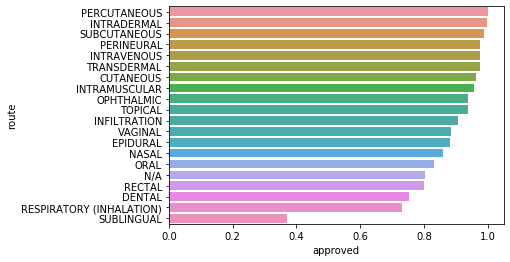

In [58]:
sns.barplot(
    x=approval_by_route,
    y=approval_by_route.index
)

Approval rate varies quite a bit by route, so route could have some predictive power. 

Now let's look at the Drug Labeling data. 

In [59]:
label = pd.read_csv('data/label.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
label.describe()

,effective_time
count,1.980120e+05
mean,2.020660e+07
std,6.361720e+06
min,1.978102e+07
25%,2.017063e+07
50%,2.019122e+07
75%,2.021033e+07
max,2.010110e+09


In [61]:
label.nunique()

id                   198012
set_id               198012
version                1077
effective_time         4708
drug_interactions     21271
dtype: int64

In [62]:
label.isna().sum()/len(label)

id                   0.000000
set_id               0.000000
version              0.000000
effective_time       0.000000
drug_interactions    0.739773
dtype: float64

id is the table's primary key. 